In [1]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

%load_ext autoreload

In [2]:
%autoreload
import sys
sys.path.insert(0, "../")

import warnings

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle

from sklearn import metrics

from mnist_experiment_utils import load_data, get_model
from experiment_utils import plot_history

from keras.optimizers import SGD

from gradient_memory import GradientMemory

/home/sicarbonnell/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Train loss: 0.26417280435562135
Train accuracy: 1.0
Test loss: 1.1353631994247437
Test accuracy: 0.718


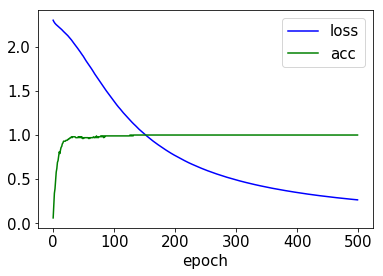

In [12]:
experiment = 0
x_train, y_train, x_test, y_test = load_data(experiment)
model = get_model(experiment)

# parameters for recording of the gradients during training
batch_frequency = 1 # once per epoch since all data goes into one batch
nb_samples_stored = 5000
nb_neurons_stored = np.inf
sample_indices = np.random.choice(x_test.shape[0],min(x_test.shape[0],nb_samples_stored)) # test samples!
neuron_indices = np.random.choice(784,min(784,nb_neurons_stored))


lr = 1
batch_size = 128
epochs = 500
verbose = 0

for l in model.layers:
    if l.name != 'dense0':
        l.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr),
              metrics=['accuracy'])
            
gradstore = GradientMemory(model.get_layer('dense0'), model, 
                           x_test,
                           y_test, 
                           sample_indices,
                           neuron_indices,
                           batch_frequency = batch_frequency)

warnings.filterwarnings("ignore") # to remove Keras' warning for slow callback

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    callbacks = [gradstore])

score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

score_test = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score_test[0])
print('Test accuracy:', score_test[1])

plot_history(history)

gradients = np.array(gradstore.gradients_accumulator)
np.save('first_layer_feedback.npy',gradients)

In [15]:
m = []
for i in range(gradients.shape[0]):
    m.append(metrics.silhouette_score(gradients[i], np.where(y_test[sample_indices])[1], metric='cosine'))

with open('first_layer_feedback_silhouette.p','wb') as f:
    pickle.dump(m,f)

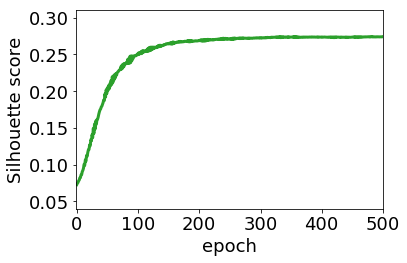

In [3]:
%matplotlib inline
with open('first_layer_feedback_silhouette.p','rb') as f:
    m = pickle.load(f)

matplotlib.rcParams.update({'font.size': 18})

plt.plot(range(len(m)),m,linewidth=3.0, color = 'C2')
plt.xlabel('epoch')
plt.ylabel('Silhouette score')
plt.ylim(0.04,0.31)
plt.xlim(-0.5,500)
plt.xticks([0,100,200,300,400,500])
plt.yticks([0.05,0.1,0.15,0.2,0.25,0.3])

plt.tight_layout()

plt.savefig('figures/MNIST_feedbackAnalysis.eps',format='eps', dpi=200)
# plt.savefig('figures/MNIST_feedbackAnalysis.png',format='png', dpi=300)